In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import linear_model, svm, discriminant_analysis, metrics
from scipy import optimize
import seaborn as sns

In [2]:
def acc(Yp,Y):
    incorrect=0
    for i in range(0,len(Yp)):
        if (Yp[i]!=Y[i]):
            incorrect+=1
    return (len(Yp)-incorrect)/len(Yp)

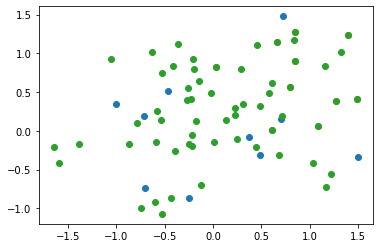

In [3]:
N=10
sigm=0.5


x1 = np.random.multivariate_normal([0, 0.1], np.diag([sigm, sigm]), size=N)
x2 = np.random.multivariate_normal([0.9, 1], np.diag([sigm, sigm]), size=N)

x4 = np.random.multivariate_normal([0, 0.1], np.diag([sigm, sigm]), size=5*N)
x5 = np.random.multivariate_normal([0.9, 1], np.diag([sigm, sigm]), size=5*N)
x3=np.concatenate([x2,x4])

x6 = np.random.multivariate_normal([0, 0.1], np.diag([sigm, sigm]), size=10*N)
x7 = np.random.multivariate_normal([0.9, 1], np.diag([sigm, sigm]), size=10*N)
x_test=np.concatenate([x6,x7])
y_test = np.concatenate([np.ones(10*N), np.ones(10*N)*-1])


plt.scatter(x1[:, 0], x1[:, 1])
plt.scatter(x2[:, 0], x2[:, 1])
plt.scatter(x3[:, 0], x3[:, 1])

In [4]:
X = np.concatenate([x1, x2])
Y = np.concatenate([np.ones(N), np.ones(N)*-1])



In [5]:
class KernelSvmClassifier:
    
    def __init__(self, C, kernel):
        self.C = C                               
        self.kernel = kernel          # <---
        self.alpha = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        # --->
        # Gram matrix of h(x) y
        hXX = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  self.kernel(x1, x2), 1, X),
                                  1, X)   
        yp = y.reshape(-1, 1)
        GramHXy = hXX * np.matmul(yp, yp.T) 
        # <---

        # Lagrange dual problem
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        # Partial derivate of Ld on alpha
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = np.vstack((-np.eye(N), np.eye(N)))             # <---
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))  # <---
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y),     'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramHXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramHXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        # --->
        epsilon = 1e-8
        supportIndices = self.alpha > epsilon
        self.supportVectors = X[supportIndices]
        self.supportAlphaY = y[supportIndices] * self.alpha[supportIndices]
        # <---
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        # --->
        def predict1(x):
            x1 = np.apply_along_axis(lambda s: self.kernel(s, x), 1, self.supportVectors)
            x2 = x1 * self.supportAlphaY
            return np.sum(x2)
        
        d = np.apply_along_axis(predict1, 1, X)
        return 2 * (d > 0) - 1
        # <---

In [6]:
def GRBF(x1, x2,gamma=7):
    diff = x1 - x2
    return np.exp(-gamma*np.dot(diff, diff) * len(x1) / 2)

def my_RBF(X, Y, gamma=1):
    X_norm = np.sum(X ** 2, axis=-1)
    Y_norm = np.sum(Y ** 2, axis=-1)
    K = np.exp(-gamma * (X_norm[:, None] + Y_norm[None, :] - 2 * np.dot(X, Y.T)))
    return K


model=None
model = KernelSvmClassifier(C=5, kernel=GRBF)
model.fit(X, Y)

In [7]:
x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 50)
y_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 50)

In [8]:
XX, YY = np.meshgrid(x_range, y_range)

In [9]:
cls = model.predict(np.c_[XX.flatten(), YY.flatten()])

In [10]:
acc(model.predict(x_test),y_test)

0.695

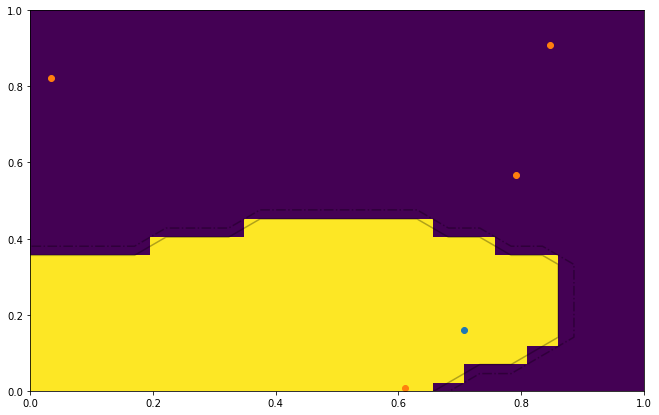

In [11]:
fig, ax = plt.subplots(1, figsize=(11, 7))

ax.set_xlim(0,1)
ax.set_ylim(0,1)


plt.pcolormesh(XX, YY, cls.reshape(XX.shape[0], XX.shape[1]), shading='auto')
bord=ax.contour(XX, YY, cls.reshape(XX.shape[0], XX.shape[1]), colors='k', levels=[-1, 0], alpha=0.3, linestyles=['-.', '-']);
plt.scatter(x1[:, 0], x1[:, 1])
plt.scatter(x2[:, 0], x2[:, 1])
#plt.scatter(x3[:, 0], x3[:, 1])

In [12]:
X_bord, Y_bord = bord.collections[0].get_paths()[0].vertices.T
border=[X_bord,Y_bord]

In [13]:
#используем неразмеченные данные

eps=0.01 #близость к границе
epochs=1

for i in range(0,epochs):
    filtered=None
    uncl=None
    filtered=[]

    #фильтр по расстоянию
    for i in x3:
        f=0;
        for j in border:
            if (((i[0]-j[0])**2+(i[1]-j[1])**2)**1/2<eps):
                f=1
                break;
        if (f==0):
            filtered.append(i)

    #разметка неразмеченных точек
    uncl=model.predict(filtered)
    X_new = np.concatenate([X, filtered])
    Y_new = np.concatenate([Y, uncl])

    #корректировка модели
    model.fit(X_new,Y_new)


In [14]:
acc(model.predict(x_test),y_test)

0.72

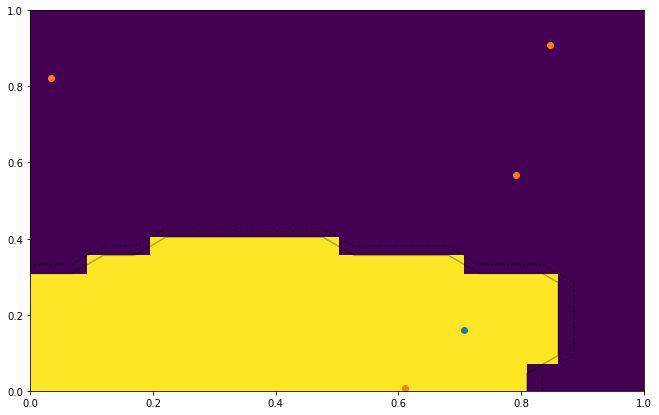

In [15]:
cls = model.predict(np.c_[XX.flatten(), YY.flatten()])

fig, ax = plt.subplots(1, figsize=(11, 7))
ax.set_xlim(0,1)
ax.set_ylim(0,1)

plt.pcolormesh(XX, YY, cls.reshape(XX.shape[0], XX.shape[1]), shading='auto')
bord=ax.contour(XX, YY, cls.reshape(XX.shape[0], XX.shape[1]), colors='k', levels=[-1, 0], alpha=0.3, linestyles=['-.', '-']);
plt.scatter(x1[:, 0], x1[:, 1])
plt.scatter(x2[:, 0], x2[:, 1])
#plt.scatter(x3[:, 0], x3[:, 1])